<a href="https://colab.research.google.com/github/maulanaakbardj/eKYC_IdCard/blob/main/OCR_KTP_easyocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install easyocr
!pip install nameparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download data json wilayah
!wget -L https://raw.githubusercontent.com/mul14/nik_parser.ts/master/src/wilayah.json

--2022-05-27 08:43:42--  https://raw.githubusercontent.com/mul14/nik_parser.ts/master/src/wilayah.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272438 (266K) [text/plain]
Saving to: ‘wilayah.json.1’

wilayah.json.1      100%[===================>] 266.05K  --.-KB/s    in 0.004s  

2022-05-27 08:43:43 (63.5 MB/s) - ‘wilayah.json.1’ saved [272438/272438]



In [3]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import ImageDraw
from PIL import Image
import numpy as np
from google.colab import files
import json
 
# config easyocr
import easyocr
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu = True if device.type == 'cuda' else  False

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
 
class processing():
  def shi_tomashi(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 4, 0.01, 100)
    corners = np.int0(corners)
    corners = sorted(np.concatenate(corners).tolist())
    return corners
 
 
  def get_destination_points(corners):
      w1 = np.sqrt((corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2)
      w2 = np.sqrt((corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2)
      w = max(int(w1), int(w2))
 
      h1 = np.sqrt((corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2)
      h2 = np.sqrt((corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2)
      h = max(int(h1), int(h2))
 
      destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])
      return destination_corners, h, w
 
 
  def unwarp(img, src, dst):
      h, w = img.shape[:2]
      H, _ = cv2.findHomography(src, dst, method=cv2.RANSAC, ransacReprojThreshold=3.0)
      un_warped = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_LINEAR)
      # plot
 
      f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
      # f.subplots_adjust(hspace=.2, wspace=.05)
      ax1.imshow(img)
      ax1.set_title('Original Image')
 
      x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
      y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
 
      ax2.imshow(img)
      ax2.plot(x, y, color='yellow', linewidth=3)
      ax2.set_ylim([h, 0])
      ax2.set_xlim([0, w])
      ax2.set_title('Target Area')
 
      plt.show()
      return un_warped
 
  def apply_filter(image):
      gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      kernel = np.ones((4, 4), np.float32) / 15
      filtered = cv2.filter2D(gray, -1, kernel)
      return filtered
 
  def apply_threshold(filtered):
      ret, thresh = cv2.threshold(filtered, 255, 255, cv2.THRESH_OTSU)
      return thresh
 
  def detect_contour(img, image_shape):
      canvas = np.zeros(image_shape, np.uint8)
      contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
      cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
      return canvas, cnt
 
  def detect_corners_from_contour(canvas, cnt):
      epsilon = 0.02 * cv2.arcLength(cnt, True)
      approx_corners = cv2.approxPolyDP(cnt, epsilon, True)
      cv2.drawContours(canvas, approx_corners, -1, (255, 255, 0), 10)
      approx_corners = sorted(np.concatenate(approx_corners).tolist())
 
      # Dinamic Sorted
      sum_approx_corners = [sum(i) for i in approx_corners]
      sorted_index_asc =  sorted(range(len(sum_approx_corners)), key=lambda k: sum_approx_corners[k], reverse=False)
      sorted_index_dsc =  sorted(range(len(sum_approx_corners)), key=lambda k: sum_approx_corners[k], reverse=True)
 
      minA = sorted_index_asc[0]
      maxB = sorted_index_dsc[1]
      minC = sorted_index_asc[1]
      maxD = sorted_index_dsc[0]
 
      # Rearranging the order of the corner points
      approx_corners = [approx_corners[i] for i in [minA, maxB, minC, maxD]]
      return approx_corners
 
def prespective(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  filtered_image = processing.apply_filter(image)
  threshold_image = processing.apply_threshold(filtered_image)
  cnv, largest_contour = processing.detect_contour(threshold_image, image.shape)
  corners = processing.detect_corners_from_contour(cnv, largest_contour)
  destination_points, h, w = processing.get_destination_points(corners)
  un_warped = processing.unwarp(image, np.float32(corners), destination_points)
  cropped = un_warped[0:h, 0:w]
  return cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)

In [5]:
class ocrIdCard():
  reader = easyocr.Reader(['id'], gpu=gpu)
 
  def processOcr(img):
    result = ocrIdCard.reader.readtext(
          img, 
          detail = 1,
          batch_size  = 1,
          text_threshold = 0.7,
          blocklist = '?/=! ',
          low_text = 0.4,
          link_threshold = 0.9, # 0.7
          slope_ths = 0.1,
          adjust_contrast =0.9
          # paragraph = True
      )
    return result
 
  def drawBoxes(image, bounds, color='red', width=2):
    text = []
    confidence = []
    image = Image.fromarray(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image)
 
    for bound in bounds:
        confidence.append(bound[2])
        text.append(bound[1])
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    
    # Calculate AVG confidence level
    avgConf = sum(confidence)/len(confidence)
    return image, text, avgConf

In [6]:
import datetime
 
fileJson = open('wilayah.json',)
data = json.load(fileJson) 
 
provinces = data['provinsi']
citys     = data['kabkot']
districts = data['kecamatan']
 
dictParserNik = {
    'nik'       : None,
    'nama'      : None,
    'kelamin'   : None,
    'golDarah'  : None,
    'tglLahir'  : None,
    'provinsi'  : None,
    'kotaKab'   : None,
    'kecamatan' : None,
    'kodePos'   : None
}
 
def parserNik(nik):
  datetimeNow = datetime.datetime.now()
  yearNow     = str(datetimeNow.year)[:-2]
 
  year        = '19'+nik[10:12] if int(yearNow) < int(nik[10:12]) else '20'+nik[10:12]
  month       = nik[8:10]
  day         = nik[6:8]
  birthday    = f'{day}-{month}-{year}'
 
  provinceId  = nik[:2]
  cityId      = nik[:4]
  districtsId = nik[:6]
 
  dictParserNik['nik']        = nik
  dictParserNik['tglLahir']   = birthday
  dictParserNik['provinsi']   = provinces[provinceId]
  dictParserNik['kotaKab']    = citys[cityId]
  dictParserNik['kecamatan']  = districts[districtsId].split('--')[0]
  dictParserNik['kodePos']    = districts[districtsId].split('--')[1]
  return dictParserNik#json.dumps(dictParserNik, sort_keys=False)

In [7]:
!mkdir uploads

mkdir: cannot create directory ‘uploads’: File exists


In [8]:
uploaded = files.upload()
uploaded_files = list(uploaded.keys())
for uploaded_file in uploaded_files:
  print(uploaded_file)
  !mv $uploaded_file uploads/$uploaded_file

Saving alias-wello-ktp-bintan.jpg to alias-wello-ktp-bintan.jpg
alias-wello-ktp-bintan.jpg


In [9]:
PATH_IMAGE = 'uploads/' 
image = cv2.imread(PATH_IMAGE+uploaded_file)

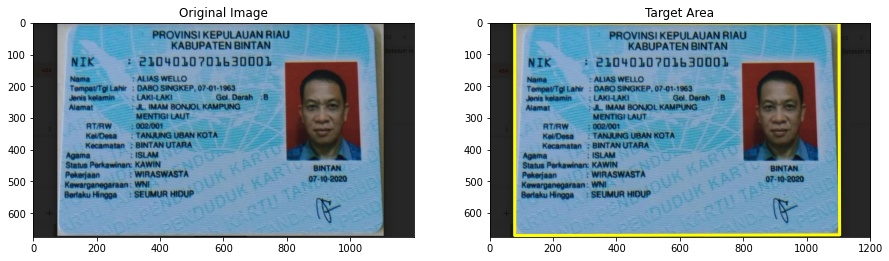

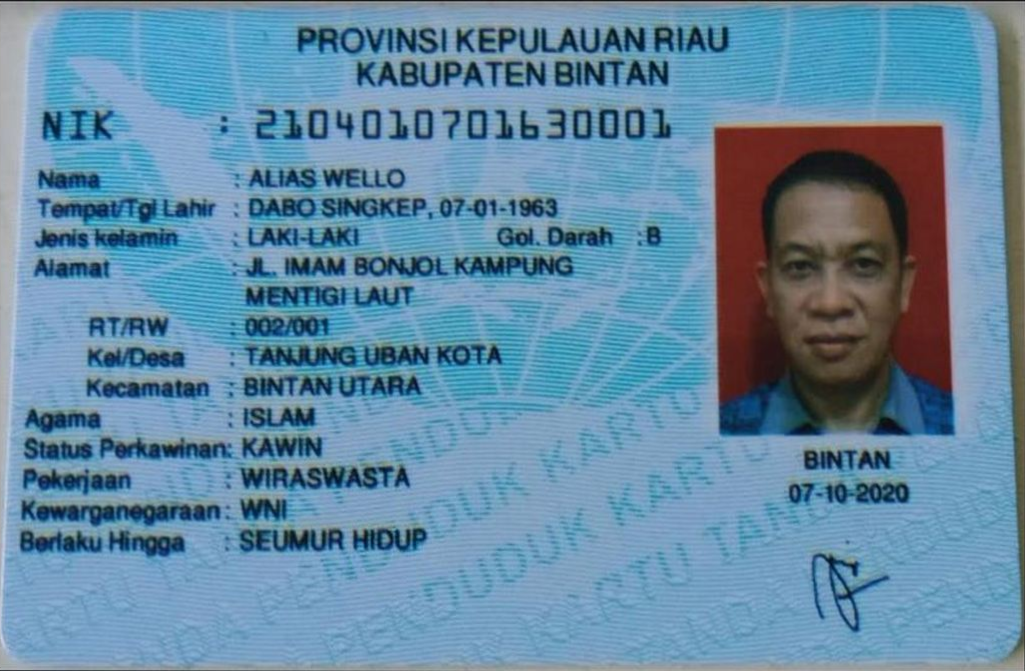

In [10]:
imagePrespective = prespective(image)
cv2_imshow(imagePrespective)

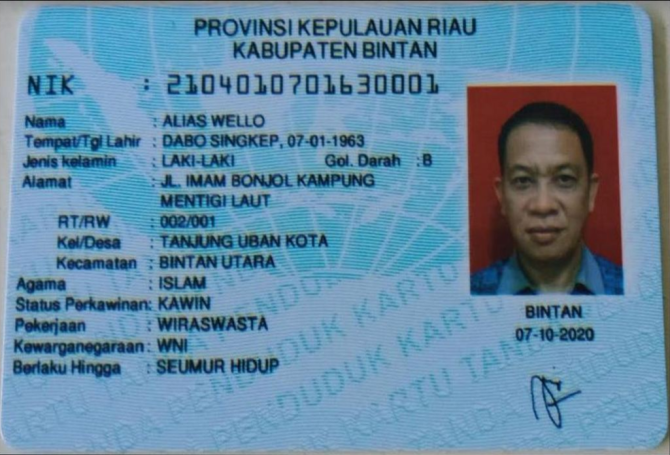

In [11]:
width = 670
height = 455
dim = (width, height)
imgResized = cv2.resize(imagePrespective, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(imgResized)

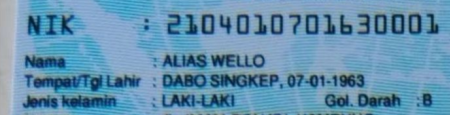

In [12]:
imgCropped = nik = imgResized[60:175, 0:width-220]
cv2_imshow(imgCropped)

In [13]:
processedOcr = ocrIdCard.processOcr(img=imgCropped)
imageDraw, text, confidence = ocrIdCard.drawBoxes(imgCropped, processedOcr)
text

['NIK',
 '2104010701630001',
 'Nama',
 'AliasWello',
 'TempatTdLahir',
 'DABOSINGKEP,07-01-1963',
 'Jonskelam',
 'LAKI-UAKI',
 'Gol.Derah']

In [14]:
import re
 
query = ' '.join(word for word in text)
stopwords = {'nik', 'mik','nama', 'nam', 'tempat', 'tgl', 'lahir',
             'jenis', 'temoattglLahir', 'temoattgllahir', 'kelamin', 
             'feniaelami','gol', 'darah', 'niselami'}
 
resultwords  = [word for word in re.split("\W+",query) if word.lower() not in stopwords]
print(resultwords)

['2104010701630001', 'AliasWello', 'TempatTdLahir', 'DABOSINGKEP', '07', '01', '1963', 'Jonskelam', 'LAKI', 'UAKI', 'Derah']


In [15]:
from nameparser import HumanName

textStr = ' '.join(word for word in resultwords if word.isnumeric() == False and word not in ['LAKILAKI', 'PEREMPUAN', 'LAKI-LAKI', 'PEHEMPUAN'] and len(word) != 1)
gotName = HumanName(textStr)
nama = f'{gotName.first}'
nama

'AliasWello'

In [16]:
nik = None
golDarah = None
jenKelamin = None

for word in resultwords:
  if len(word) == 16:
    if word.isnumeric() == True:
      nik = word
  if word in ['A', 'O', 'B', 'AB']:
    golDarah = word
  if word in ['LAKILAKI', 'PEREMPUAN', 'LAKI-LAKI', 'LAKI', 'PEHEMPUAN']:
    if word == 'LAKILAKI'or word == 'LAKI-LAKI' or word == 'LAKI':
      jenKelamin = 'LAKI-LAKI'
    elif word == 'PEHEMPUAN' or word == 'PEREMPUAN':
      jenKelamin = 'PEREMPUAN'

In [17]:
extractkNik = parserNik(nik)
extractkNik['nama'] = nama
extractkNik['kelamin'] = jenKelamin
extractkNik['golDarah'] = golDarah
print(extractkNik)


{'nik': '2104010701630001', 'nama': 'AliasWello', 'kelamin': 'LAKI-LAKI', 'golDarah': None, 'tglLahir': '07-01-1963', 'provinsi': 'KEPULAUAN RIAU', 'kotaKab': 'KAB. LINGGA', 'kecamatan': 'SINGKEP ', 'kodePos': ' 29875'}


In [18]:
from pprint import pprint
pprint(extractkNik)


{'golDarah': None,
 'kecamatan': 'SINGKEP ',
 'kelamin': 'LAKI-LAKI',
 'kodePos': ' 29875',
 'kotaKab': 'KAB. LINGGA',
 'nama': 'AliasWello',
 'nik': '2104010701630001',
 'provinsi': 'KEPULAUAN RIAU',
 'tglLahir': '07-01-1963'}
